In [1]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer

from pyspark import SparkContext

SparkContext.setSystemProperty('spark.executor.memory', '7g')


#data = sc.textFile("data.csv").map(lambda line:
#line.split(",")).map(lambda record: (record[0], record[1]))

data_df = spark.read.csv(path='processed_data/dataset_final.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

#indexer = StringIndexer(inputCol="lable", outputCol="label")
#data_df = indexer.fit(raw_data).transform(raw_data).select("url", "label")

In [2]:
#Tokennize the TrainData
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#determing components to be removed in the URL
add_stopWords = ["http", "https", "www"]

#Removing the stop words  from the tokenized data
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="Filtered").setStopWords(add_stopWords)

#Convert the words to ngrams
ngram = NGram(n=2, inputCol=stopwordsRemover.getOutputCol(), outputCol="Ngrams")

#Hashing the data
hashingTF = HashingTF(inputCol=stopwordsRemover.getOutputCol(), outputCol="rawFeatures")

idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features") 

countVectors = CountVectorizer(inputCol=stopwordsRemover.getOutputCol(), outputCol="features", vocabSize=10000, minDF=5)

#creating the pipepline of steps to be performed in oreder
pipeline = Pipeline(stages=[regexTokenizer,stopwordsRemover, countVectors])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data_df)

#Transform the pipeline to dataset
dataset = pipelineFit.transform(data_df)

#randomly split the dataset to traning and testing 70%, 30% respectively
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
trainingData.show()

Training Dataset Count: 838107
Test Dataset Count: 360039
+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|            Filtered|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|0-0-0-0-0-0-0-0-0...|    1|[0, 0, 0, 0, 0, 0...|[0, 0, 0, 0, 0, 0...|(10000,[10,141,90...|
|0-0-0-0-0-0-0-0-0...|    1|[0, 0, 0, 0, 0, 0...|[0, 0, 0, 0, 0, 0...|(10000,[10,141,36...|
|              0-g.us|    1|          [0, g, us]|          [0, g, us]|(10000,[6,141,291...|
|        0000love.net|    1|     [0000love, net]|     [0000love, net]|   (10000,[3],[1.0])|
|      0001.2waky.com|    1|  [0001, 2waky, com]|  [0001, 2waky, com]|   (10000,[0],[1.0])|
|000lk3v.wcomhost.com|    1|[000lk3v, wcomhos...|[000lk3v, wcomhos...|(10000,[0,3128,51...|
|001547.000webhost...|    1|[001547, 000webho...|[001547, 000webho...|(10000,[0,61],[1....|
|     001linker.net;1|

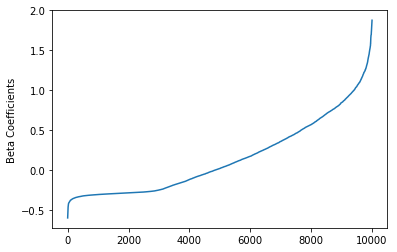

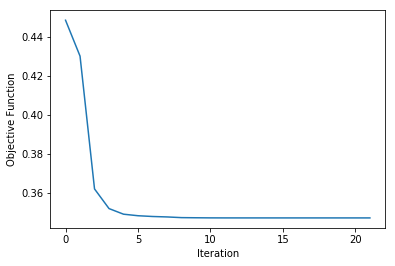

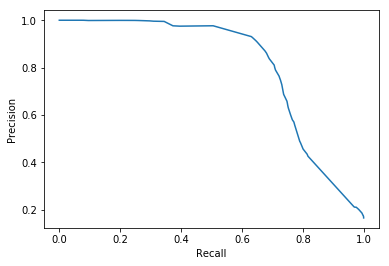

+-------------------------------------+-----+----------+
|                                  url|label|prediction|
+-------------------------------------+-----+----------+
|           0000mps.webpreview.dsl.net|    1|       0.0|
|                 000lkub.rcomhost.com|    1|       0.0|
|                 000ll4q.rcomhost.com|    1|       0.0|
|                 000lp59.wcomhost.com|    1|       0.0|
|00capital0neservice.000webhostapp.com|    1|       0.0|
|                        0104joe.com;1|    1|       0.0|
|                    0107-2-384a.com;1|    1|       0.0|
|               019201.webcindario.com|    1|       0.0|
|                             01lm.com|    1|       0.0|
|                         01o5ubr.work|    1|       0.0|
+-------------------------------------+-----+----------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 0.342691

Accuracy on Test Data = 88.6068


In [3]:
#==============[ LOGISTIC REGRESSION ]=========================

# Build logistic regresssion model
lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")

# Train model using logisitic regression
lrModel = lr.fit(trainingData)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Doing the prediction using test data
#Label is not used in test data
predictions = lrModel.transform(testData)

predictions.select("url", "label", "prediction").show(n=10, truncate = 100)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("\nAccuracy on Test Data = %g" % (accuracy*100))

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
#print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#predictions.filter(predictions['prediction'] == 0) \
#    .select("url", "label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 80)

In [4]:
#==============[ RANDOM FOREST ]=========================

rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

#Train model using random forest
rfModel = rf.fit(trainingData)

#Doing the prediction using test data
#Label is not used in test data
predictions = rfModel.transform(testData)

predictions.select("url", "label", "prediction").show(n=10, truncate = 100)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("\nAccuracy on Test Data = %g" % (accuracy*100))

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
#print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#predictions.filter(predictions['prediction'] == 0) \
#    .select("url", "label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 80)

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)


ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)


ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_cl

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44101)
Traceback (most recent call last):
  File "/home/rh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-109234a503a4>", line 6, in <module>
    rfModel = rf.fit(trainingData)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/spark-2.3.0-bin-hadoop2.7/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/spa

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:44101)